In [1]:
"""
Start from an Anaconda installation of python 3.10+.
Make sure the following packages are installed by running the following:

`conda install ipython jupyter matplotlib numpy pandas tqdm`

Also install PyTorch, following the instructions at "https://pytorch.org/get-started/locally/"
"""

import functools
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tqdm.notebook as tqdm
import urllib

try:
    import torch
except ImportError:
    raise ImportError(
        "PyTorch is not installed. "
        "See https://pytorch.org/get-started/locally/ for installation instructions. "
        "(If possible, install with CUDA/GPU support.)"
    )
    
try:
    import gpytorch
except ImportError:
    %pip install gpytorch
    import gpytorch

    
try:
    import rdkit
except ImportError:
    %pip install rdkit
    import rdkit
from rdkit.Chem import MolFromSmiles, Descriptors, rdMolDescriptors

%matplotlib inline
DTYPE = torch.float64
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.set_default_dtype(DTYPE)

In [2]:
LayerType = "mono"
dataset_basename = "Data_set_BEs.csv"
smiles_features_cache_basename = "smiles_cache.csv"

response = "Ebin (K)"
non_smiles_features = ["C", "H", "O", "N", "Cl", "OH", "-C(O)-", "-C(O)O-", "-O-", "NH2", "CN", "-N-C(O)-", "Mass", "#atoms"]
smiles_features = ["VelE", "HBA", "HBD", "TPSA"]

In [3]:
# Helper functions
def _get_smiles_str(name: str, smiles_features_cache: pd.DataFrame) -> pd.Series:
    # If this mollecule is in the cache, no need to recompute the SMILES string and features
    # Just return the value in the cache
    if name in smiles_features_cache.index:
        return smiles_features_cache.loc[name]

    try:
        # Get SMILES string
        url = f"http://cactus.nci.nih.gov/chemical/structure/{urllib.parse.quote(name)}/smiles"
        smiles_str = urllib.request.urlopen(url).read().decode("utf8")

        # Get SMILES features
        molecule = MolFromSmiles(smiles_str)
        vale = Descriptors.NumValenceElectrons(molecule)
        hba = rdMolDescriptors.CalcNumHBA(molecule)
        hbd = rdMolDescriptors.CalcNumHBD(molecule)
        tpsa = rdMolDescriptors.CalcTPSA(molecule)

        # Add SMILES string and features to cache, for future use
        res = pd.Series([smiles_str, vale, hba, hbd, tpsa], index=["SMILES_str"] + smiles_features)
        smiles_features_cache.loc[name] = res
        
        # Return
        return res

    except:
        print(f"Error with {name}")
        return pd.Series()

In [4]:
# Load and process data
dataset_filename = os.path.join("..", "data", dataset_basename)
smiles_features_cache_filename = os.path.join("..", "data", smiles_features_cache_basename)
assert os.path.exists(dataset_filename)

# Load the csv file with data
# `df` will be a pd.DataFrame
df = pd.read_csv(dataset_filename).set_index(["Molecule", "Surface", "Reference"])
# Excludes rows without names
df = df[df["Name"].notnull()]

# Exclude rows with no binding energy
df = df[(df[response] > 1)]

# Only include the mono- or multilayer
df = df[df["Multi / Mono"] == LayerType.title()]

# Only include the pure depositions
df = df[df["Mixed/Pure"] == "Pure"]

# Only include the four most popular surfaces
if LayerType == "mono":
    df = df[df["Surface simplified"].isin(["metal", "carbon", "si", "water"])]

# Load an existing cache of SMILES features (if one exists)
# We store this cache so we don't have to recompute the SMILES string and features every time we run the script
# (Looking up the SMILES string is time consuming)
if os.path.exists(smiles_features_cache_filename):
    smiles_features_cache = pd.read_csv(smiles_features_cache_filename).set_index("Name")
else:
    smiles_features_cache = pd.DataFrame(
        [], columns=["SMILES_str"] + smiles_features, index=pd.Index([], name="Name")
    )

# Get SMILES features from the cache, if we've already seen this mollecule before
# If not, we'll compute the SMILES string and features
tqdm.tqdm.pandas(desc="Acquiring SMILES Strings")
smiles_features_df = df["Name"].progress_apply(_get_smiles_str, smiles_features_cache=smiles_features_cache)

# We've probably added new SMILES strings to the cache, so let's re-save the cache
smiles_features_cache.to_csv(smiles_features_cache_filename)

# Maybe get surface features
if LayerType == "mono":
    surface_one_hot_features_df = pd.get_dummies(
        df["Surface simplified"], prefix="surface", prefix_sep="_", dtype=df["C"].dtype
    )
else:
    surface_one_hot_features_df = pd.DataFrame()

# Concatenate non-smiles features, smiles features, and surface features
df = pd.concat([df, surface_one_hot_features_df, smiles_features_df], axis=1)

# Get relevant columns from dataframe
columns = non_smiles_features + surface_one_hot_features_df.columns.tolist() + smiles_features + [response]
df = df[columns]

# Drop columns with no variation
df.drop(df.columns[df.std(axis=0) < 1e-6], axis=1, inplace=True)  

# Done!
df

Acquiring SMILES Strings:   0%|          | 0/140 [00:00<?, ?it/s]

C  \
Molecule   Surface                             Reference                             
C6H4Cl2    HOPG                                Ulbricht+2006                   6.0   
C10H13N5O3 Au(100)                             Demers+2002                    10.0   
C10H13N5O4 Au(100)                             Demers+2002                    10.0   
CH3CHO     Ni                                  Corazzi+2021                    2.0   
           ASW                                 Lasne+2012                      2.0   
...                                                                            ...   
C53H108    Graphite                            Paserba+2001a,b, Gellman+2052  53.0   
C43H88     Graphite                            Paserba+2001a,b, Gellman+2042  43.0   
C33H68     Graphite                            Paserba+2001a,b, Gellman+2032  33.0   
C11H24     Graphite                            Paserba+2001a,b, Gellman+2008  11.0   
H2O        Forsterite (Mg$_{2}$SiO$_{4}$(011)) Smith+2014a                     0.0   

                                                                                  H  \
Molecule   Surface                             Reference                              
C6H4Cl2    HOPG                                Ulbricht+2006                    4.0   
C10H13N5O3 Au(100)                             Demers+2002                     13.0   
C10H13N5O4 Au(100)                             Demers+2002                     13.0   
CH3CHO     Ni                                  Corazzi+2021                     4.0   
           ASW                                 Lasne+2012                       4.0   
...                                                                             ...   
C53H108    Graphite                            Paserba+2001a,b, Gellman+2052  108.0   
C43H88     Graphite                            Paserba+2001a,b, Gellman+2042   88.0   
C33H68     Graphite                            Paserba+2001a,b, Gellman+2032   68.0   
C11H24     Graphite                            Paserba+2001a,b, Gellman+2008   24.0   
H2O        Forsterite (Mg$_{2}$SiO$_{4}$(011)) Smith+2014a                      2.0   

                                                                                O  \
Molecule   Surface                             Reference                            
C6H4Cl2    HOPG                                Ulbricht+2006                  0.0   
C10H13N5O3 Au(100)                             Demers+2002                    3.0   
C10H13N5O4 Au(100)                             Demers+2002                    4.0   
CH3CHO     Ni                                  Corazzi+2021                   1.0   
           ASW                                 Lasne+2012                     1.0   
...                                                                           ...   
C53H108    Graphite                            Paserba+2001a,b, Gellman+2052  0.0   
C43H88     Graphite                            Paserba+2001a,b, Gellman+2042  0.0   
C33H68     Graphite                            Paserba+2001a,b, Gellman+2032  0.0   
C11H24     Graphite                            Paserba+2001a,b, Gellman+2008  0.0   
H2O        Forsterite (Mg$_{2}$SiO$_{4}$(011)) Smith+2014a                    1.0   

                                                                                N  \
Molecule   Surface                             Reference                            
C6H4Cl2    HOPG                                Ulbricht+2006                  0.0   
C10H13N5O3 Au(100)                             Demers+2002                    5.0   
C10H13N5O4 Au(100)                             Demers+2002                    5.0   
CH3CHO     Ni                                  Corazzi+2021                   0.0   
           ASW                                 Lasne+2012                     0.0   
...                                                                           ...   
C53H108    Graphite                         

In [5]:
# TODO: why are there duplicate indices???
df[df.index.duplicated()]

,,,C,H,O,N,Cl,OH,-C(O)-,-C(O)O-,-O-,NH2,...,#atoms,surface_carbon,surface_metal,surface_si,surface_water,VelE,HBA,HBD,TPSA,Ebin (K)
Molecule,Surface,Reference,,,,,,,,,,,,,,,,,,,,,
HNCO,HOPG,Noble+2015,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,1.0,0.0,0.0,0.0,16,2,1,40.92,3957.0
CH4,Forsterite (Mg$_{2}$SiO$_{4}$),Suhasaria+2017,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,1.0,0.0,8,0,0,0.00,1383.0


In [6]:
# Define GPR model
class GPR(gpytorch.models.ExactGP):
    def __init__(self, X_train: torch.Tensor, y_train: torch.Tensor, eps: float = 1e-4):
        likelihood = gpytorch.likelihoods.GaussianLikelihood()

        # Compute mean/stdv for z-scoring
        X_mean = X_train.mean(dim=-2, keepdim=True)
        X_stdv = X_train.std(dim=-2, keepdim=True)
        y_mean = y_train.mean(dim=-1, keepdim=True).clamp_min(eps)  # clamp_min prevents divide-by-zero errors
        y_stdv = y_train.std(dim=-1, keepdim=True).clamp_min(eps)  # clamp_min prevents divide-by-zero errors
        X_train_zscore = (X_train - X_mean) / X_stdv
        y_train_zscore = (y_train - y_mean) / y_stdv

        # Define (z-scored) training data, likelihood, prior mean, and prior covariance
        super().__init__(X_train_zscore, y_train_zscore, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=X_train.size(-1))
        )

        # Store z-scoring moments for later use
        self.register_buffer("X_mean", X_mean)
        self.register_buffer("X_stdv", X_stdv)
        self.register_buffer("y_mean", y_mean)
        self.register_buffer("y_stdv", y_stdv)

        # Put on the right device
        self.to(dtype=X_train.dtype, device=X_train.device)

    def evaluate(self, X_test: torch.Tensor, y_test: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Compute the (standardized) R^2 and the mean NLL of the model on a given test dataset
        :return: R^2, mNLL
        """
        self.eval()
        with torch.no_grad():
            X_test_zscored = (X_test - self.X_mean) / self.X_stdv
            y_test_zscored = (y_test - self.y_mean) / self.y_stdv
            z_scored_prediction = self(X_test_zscored).to_data_independent_dist()
            rsq = 1. - (z_scored_prediction.mean - y_test_zscored).square().mean(dim=-1)
            mnll = z_scored_prediction.log_prob(y_test_zscored).mul(-1).mean(dim=-1)
        return rsq, mnll

    def forward(self, X_zscored: torch.Tensor) -> gpytorch.distributions.MultivariateNormal:
        mean = self.mean_module(X_zscored)
        covar = self.covar_module(X_zscored)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

    def learn_hyperparameters(self, num_iter: int = 400, lr: float = 0.1) -> "GPR":
        self.train()
        optimizer = torch.optim.Adam(params=self.parameters(), lr=lr)
        objective = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self)
        iterator = tqdm.tqdm(range(num_iter), desc="Optimization")

        for _ in iterator:
            optimizer.zero_grad()
            loss = -objective(self(*self.train_inputs), self.train_targets)
            loss.backward()
            optimizer.step()
            postfix = {
                "nlml": loss.item(),
                "offset": self.mean_module.constant.item(),
                "ls (avg)": self.covar_module.base_kernel.lengthscale.mean().item(),
                "signal": self.covar_module.outputscale.sqrt().item(),
                "noise": self.likelihood.noise.sqrt().item(),
            }
            iterator.set_postfix(**postfix)

        return self

    def predict(self, X: torch.Tensor) -> torch.distributions.Normal:
        self.eval()
        with torch.no_grad():
            X_zscored = (X - self.X_mean) / self.X_stdv
            z_scored_prediction = self(X_zscored)
            return gpytorch.distributions.MultivariateNormal(
                (z_scored_prediction.mean * self.y_stdv) + self.y_mean,  # un-z-scored mean
                (z_scored_prediction.lazy_covariance_matrix * self.y_stdv[..., None].square()),  # un-z-scored covariance
            )

In [7]:
# Get covariates / responses for GPR model
X = torch.tensor(df.drop(response, axis=1).values).to(dtype=DTYPE, device=DEVICE)
y = torch.tensor(df[response].values).to(dtype=DTYPE, device=DEVICE)

# Make train/validation split
n = len(df)
n_train = int(0.8 * n)
n_valid = n - n_train
train_indices, valid_indices = torch.randperm(n).split([n_train, n_valid])

# Divide the data into a training and validation set
X_train = X[train_indices]
y_train = y[train_indices]
X_valid = X[valid_indices]
y_valid = y[valid_indices]

print(f"Num train: {n_train}\nNum valid: {n_valid}\nNum covariates: {X.size(-1)}")

Num train: 112
Num valid: 28
Num covariates: 22


In [8]:
# Run model and make predictions
model = GPR(X_train, y_train).learn_hyperparameters()
rsq, mnll = model.evaluate(X_valid, y_valid)
predictions = model.predict(X_valid)
print(f"R^2: {rsq.item()}\nmNLL: {mnll.item()}")

Optimization:   0%|          | 0/400 [00:00<?, ?it/s]

R^2: 0.995533310869654
mNLL: -1.9492361341897393


In [9]:
# Compute coverage and credible interval length
cred_interval_len = 2 * predictions.stddev
is_covered = ((predictions.mean - y_valid).abs() <= cred_interval_len).cpu()
print(f"Percent of covered predictions (@ 95% credible interval): {is_covered.float().mean().item() * 100:.2f}%")

Percent of covered predictions (@ 95% credible interval): 92.86%


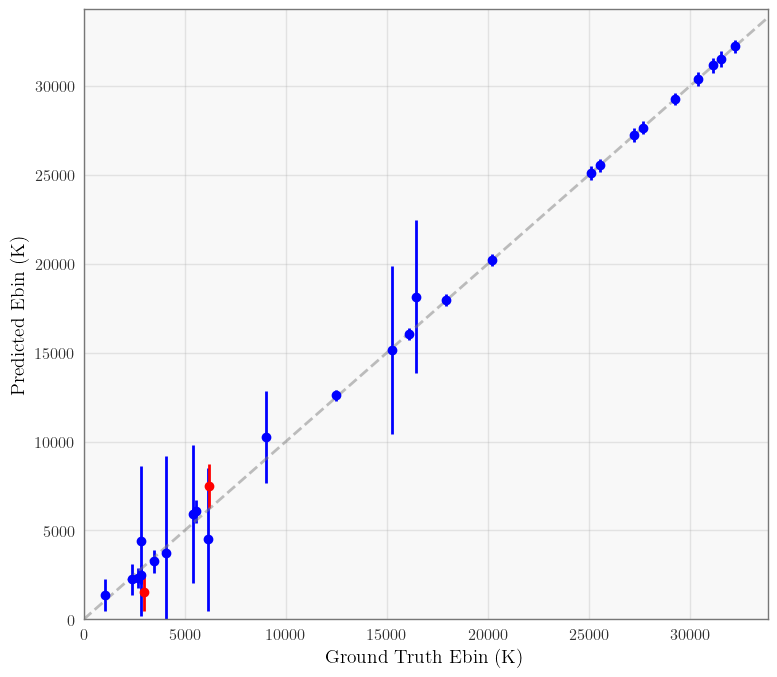

In [10]:
fig, ax = plt.subplots(figsize=(8, 7))

# Plot "correct" (covered) predictions in blue
ax.errorbar(
    y_valid[is_covered].cpu(), predictions.mean[is_covered].cpu(), yerr=(cred_interval_len[is_covered].cpu()),
    c="b", fmt="o"
)
# Plot "incorrect" (uncovered) predictions in red
ax.errorbar(
    y_valid[~is_covered].cpu(), predictions.mean[~is_covered].cpu(), yerr=(cred_interval_len[~is_covered].cpu()),
    c="r", fmt="o"
)

# Make plot pretty
ax.axline((0, 0), slope=1., color="gray", ls="--", alpha=0.5)
ax.set(
    xlim=(0, None),
    ylim=(0, None),
    xlabel=f"Ground Truth {response}",
    ylabel=f"Predicted {response}"
)
fig.tight_layout()